In [19]:
import sys
sys.path.append('../')
sys.path.append('../data_processing/')

In [22]:
from torch_geometric.loader import DataLoader
import torch

In [20]:
from data_processing.paired_data import PharmacophoreDataset, CombinedGraphDataset
from data_processing.reconstruction import get_atomic_number_from_index, is_aromatic_from_index, reconstruct_from_generated

In [9]:
root = '/data/conghao001/pharmacophore2drug/PP2Drug/data/cleaned_crossdocked_data'
split = 'test'
batch_size = 10
num_workers = 0

In [10]:
dataset = CombinedGraphDataset(root, split)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [11]:
one = next(iter(dataloader))
one

DataBatch(x=[10, 172, 13], pos=[10, 172, 3], original_x=[238, 13], original_pos=[238, 3], target_x=[10, 172, 13], target_pos=[10, 172, 3], CoM=[10, 3], node_mask=[10, 172], Gt_mask=[1720], edge_mask=[10, 29584], node_pp_index=[1, 1720], ligand_name=[10], num_nodes=238, batch=[238], ptr=[11])

In [28]:
x = one.original_x[one.batch==1]
pos = one.original_pos[one.batch==1]
x.size(), pos.size()

(torch.Size([18, 13]), torch.Size([18, 3]))

In [34]:
pos = pos.tolist()
pos

[[26.337299346923828, 2.9976000785827637, 4.181399822235107],
 [24.916799545288086, 5.399400234222412, 4.145500183105469],
 [27.008899688720703, 4.228099822998047, 4.0995001792907715],
 [26.318300247192383, 5.418099880218506, 4.07859992980957],
 [24.22920036315918, 4.17080020904541, 4.225299835205078],
 [22.492900848388672, 4.122600078582764, 4.300300121307373],
 [24.931800842285156, 2.9828999042510986, 4.247200012207031],
 [24.144500732421875, 1.6985000371932983, 4.3480000495910645],
 [29.291500091552734, 0.8658000230789185, 3.900700092315674],
 [28.24880027770996, 0.08590000122785568, 3.0738000869750977],
 [27.141399383544922, 1.1325000524520874, 2.890899896621704],
 [28.518999099731445, 1.6863000392913818, 6.220600128173828],
 [28.47719955444336, 1.9199999570846558, 4.7083001136779785],
 [30.025699615478516, -0.0406000018119812, 4.729300022125244],
 [27.067899703979492, 1.801800012588501, 4.219600200653076],
 [29.411100387573242, -0.5242000222206116, 5.303100109100342],
 [24.1938991

In [29]:
Gt_mask = one.Gt_mask.view(batch_size, -1)[1]
Gt_mask.sum()

tensor(18)

In [30]:
atom_index = torch.argmax(x, dim=1)
atom_index

tensor([ 1,  1,  1,  1,  1, 12,  1,  1,  1,  1,  1,  1,  1,  5,  3,  0,  1,  3])

In [31]:
atom_type = get_atomic_number_from_index(atom_index)
atom_type

[6, 6, 6, 6, 6, 17, 6, 6, 6, 6, 6, 6, 6, 8, 7, 1, 6, 7]

In [32]:
atom_aromatic = is_aromatic_from_index(atom_index)
atom_aromatic

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

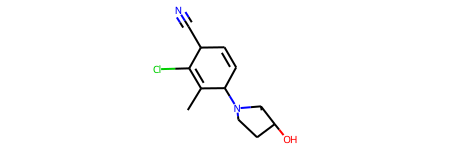

In [35]:
mol = reconstruct_from_generated(pos, atom_type, atom_aromatic)
mol